# Phase 04: Modelling

Similar to Part 01, we will be using a regression model to predict the `Thỏa thuận` price in the `Price` column.

But we are not going to use the same approach as Part 01. We are goint to use GridSearchCV to find the best models for our analysis, while tunning at the same time. We will still spend some time to compare our models, but we won't be cover them as precise as Part 01.

Let's start shall we.

### Import necessary Python modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

import joblib

### Read data from file

In [3]:
data = pd.read_csv('../Data/rent_data_ready_for_ml.csv', index_col=0)

## 1. Pre-process the data

The data is already processed after our previous phase. However, there are things we can do to improve the training process with this data, is to reduce the magnitute of the price number. For now, they are all number of over 6 digits, which could make the calculation process slower. Let's try to reduce that by changing the metric from `vnd` to `million vnd`. 

In [4]:
data['Price'] = data['Price'] / 1000000
data.rename({'Price': 'Price (million vnd)'}, inplace=True)

We also need to do is to remove the `Post data` column as we won't be using that for trainint.

In [5]:
data.drop(['Post date'], axis=1, inplace=True)

The data is now ready for training. For our model, we'll be focusing on predicting the price of `Căn hộ chung cư` property. 

In [6]:
data = data[data['Rent type'] == 'Căn hộ chung cư']

### 1.1 Detect outliner in the data

c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

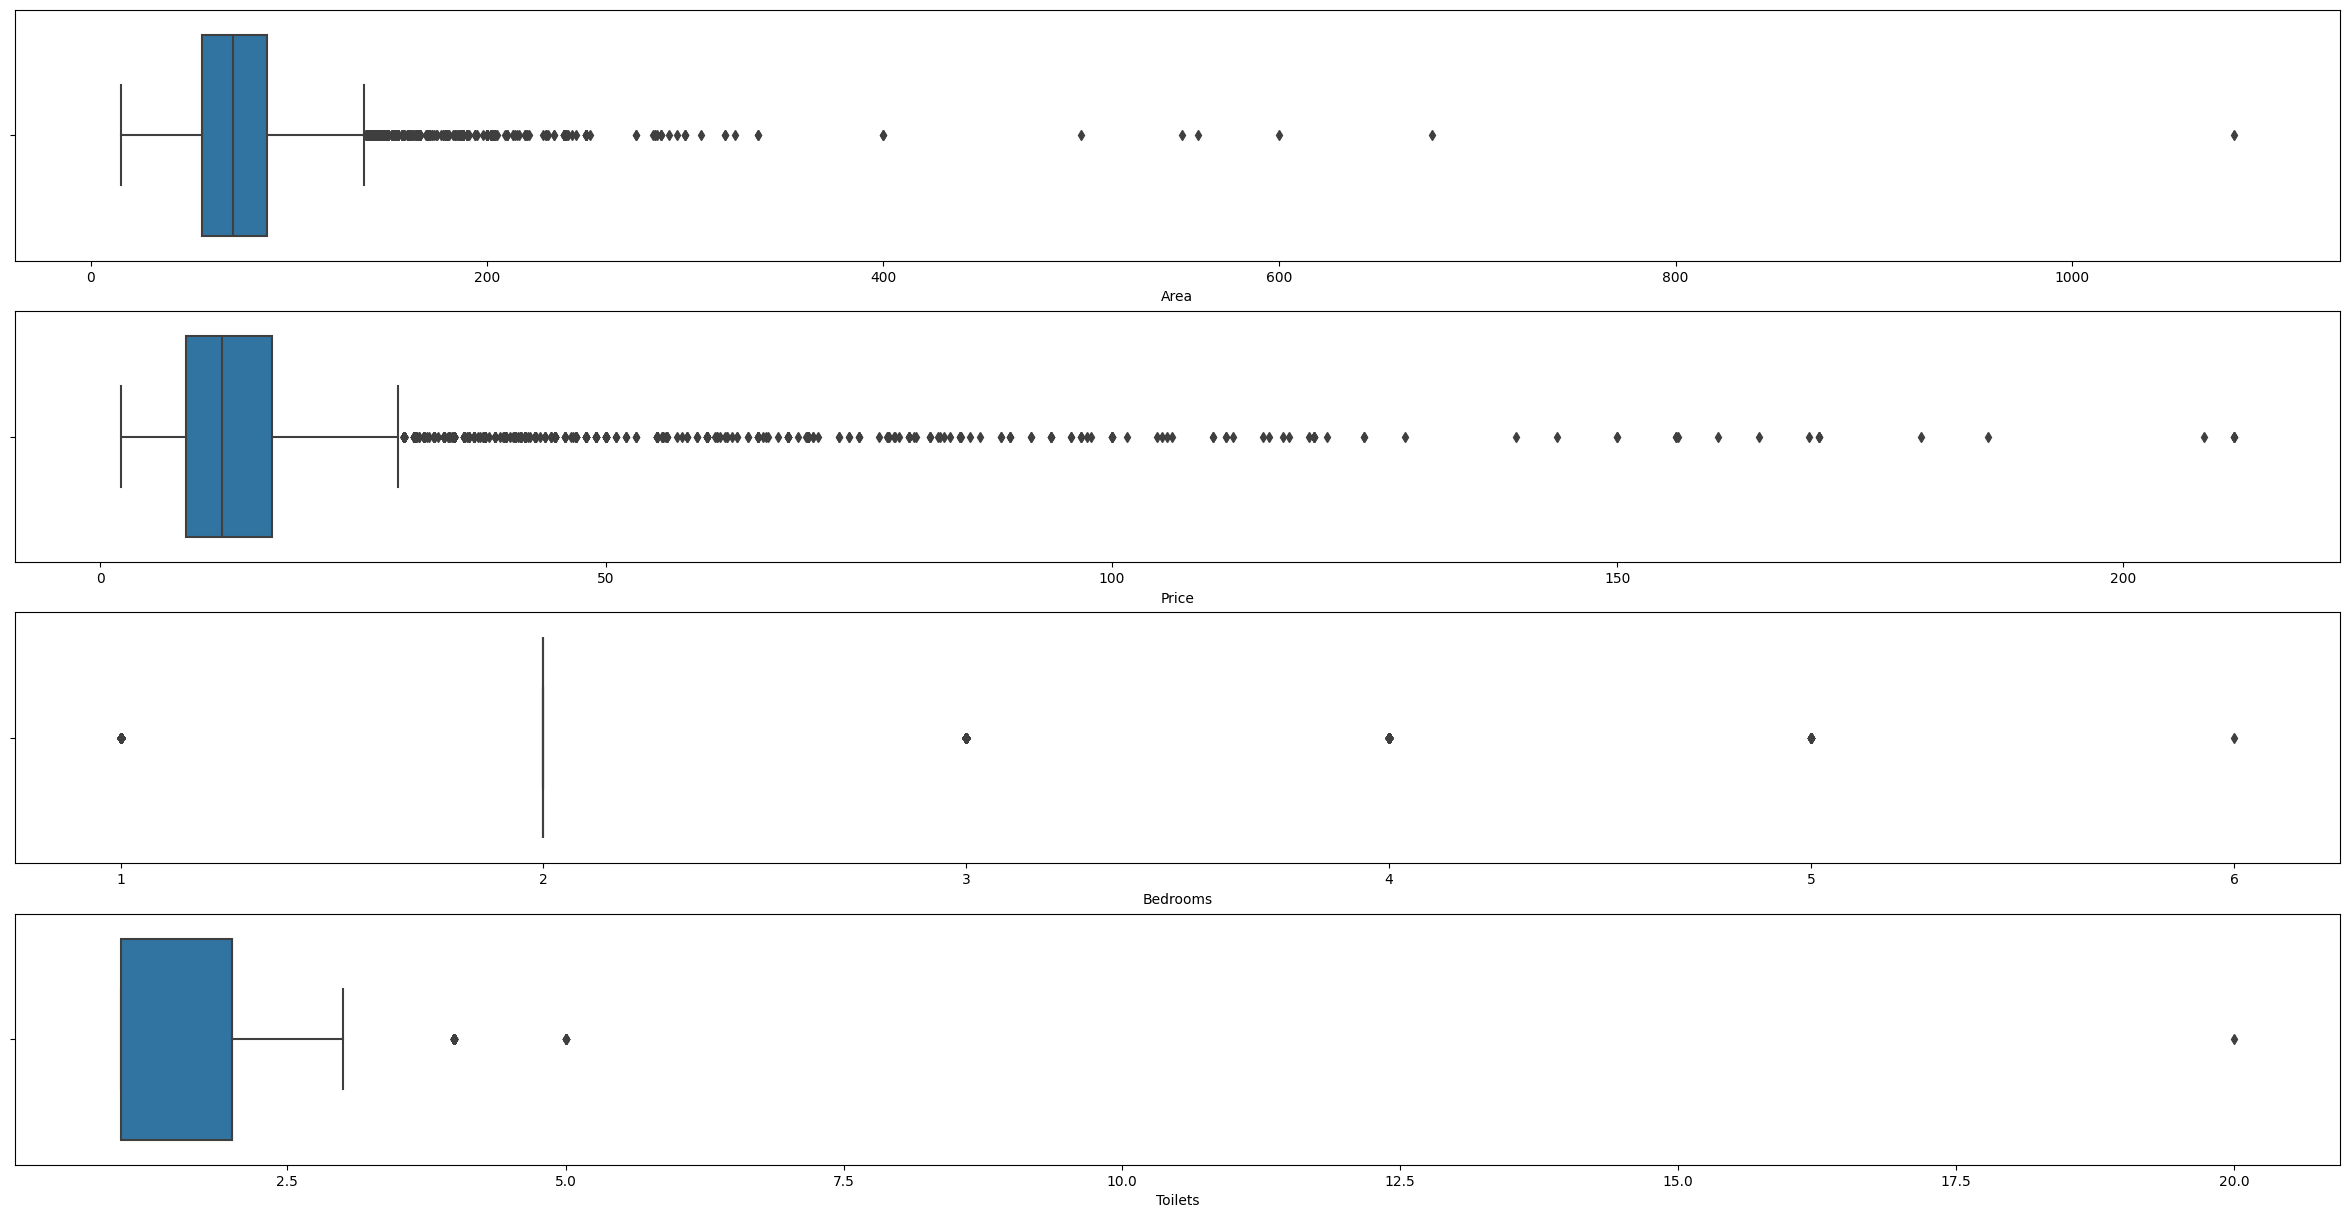

In [7]:
columns_to_plot = ['Area', 'Price', 'Bedrooms', 'Toilets']

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(30, 15))

for i, column in enumerate(columns_to_plot):
    sns.boxplot(x = data[column], ax=axes[i])

With boxplot, we can see that there are a lot of outliner in the `Area` and `Price` fields. There seems to be some outliner going on in the `Bedrooms` and `Toilets` fields too, although especially in `Toilets` as there are outliner up to values of 20. 

Since box plot show us the data but not how it's is distributed, let's try to take a closer look by plotting some histograms.

c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

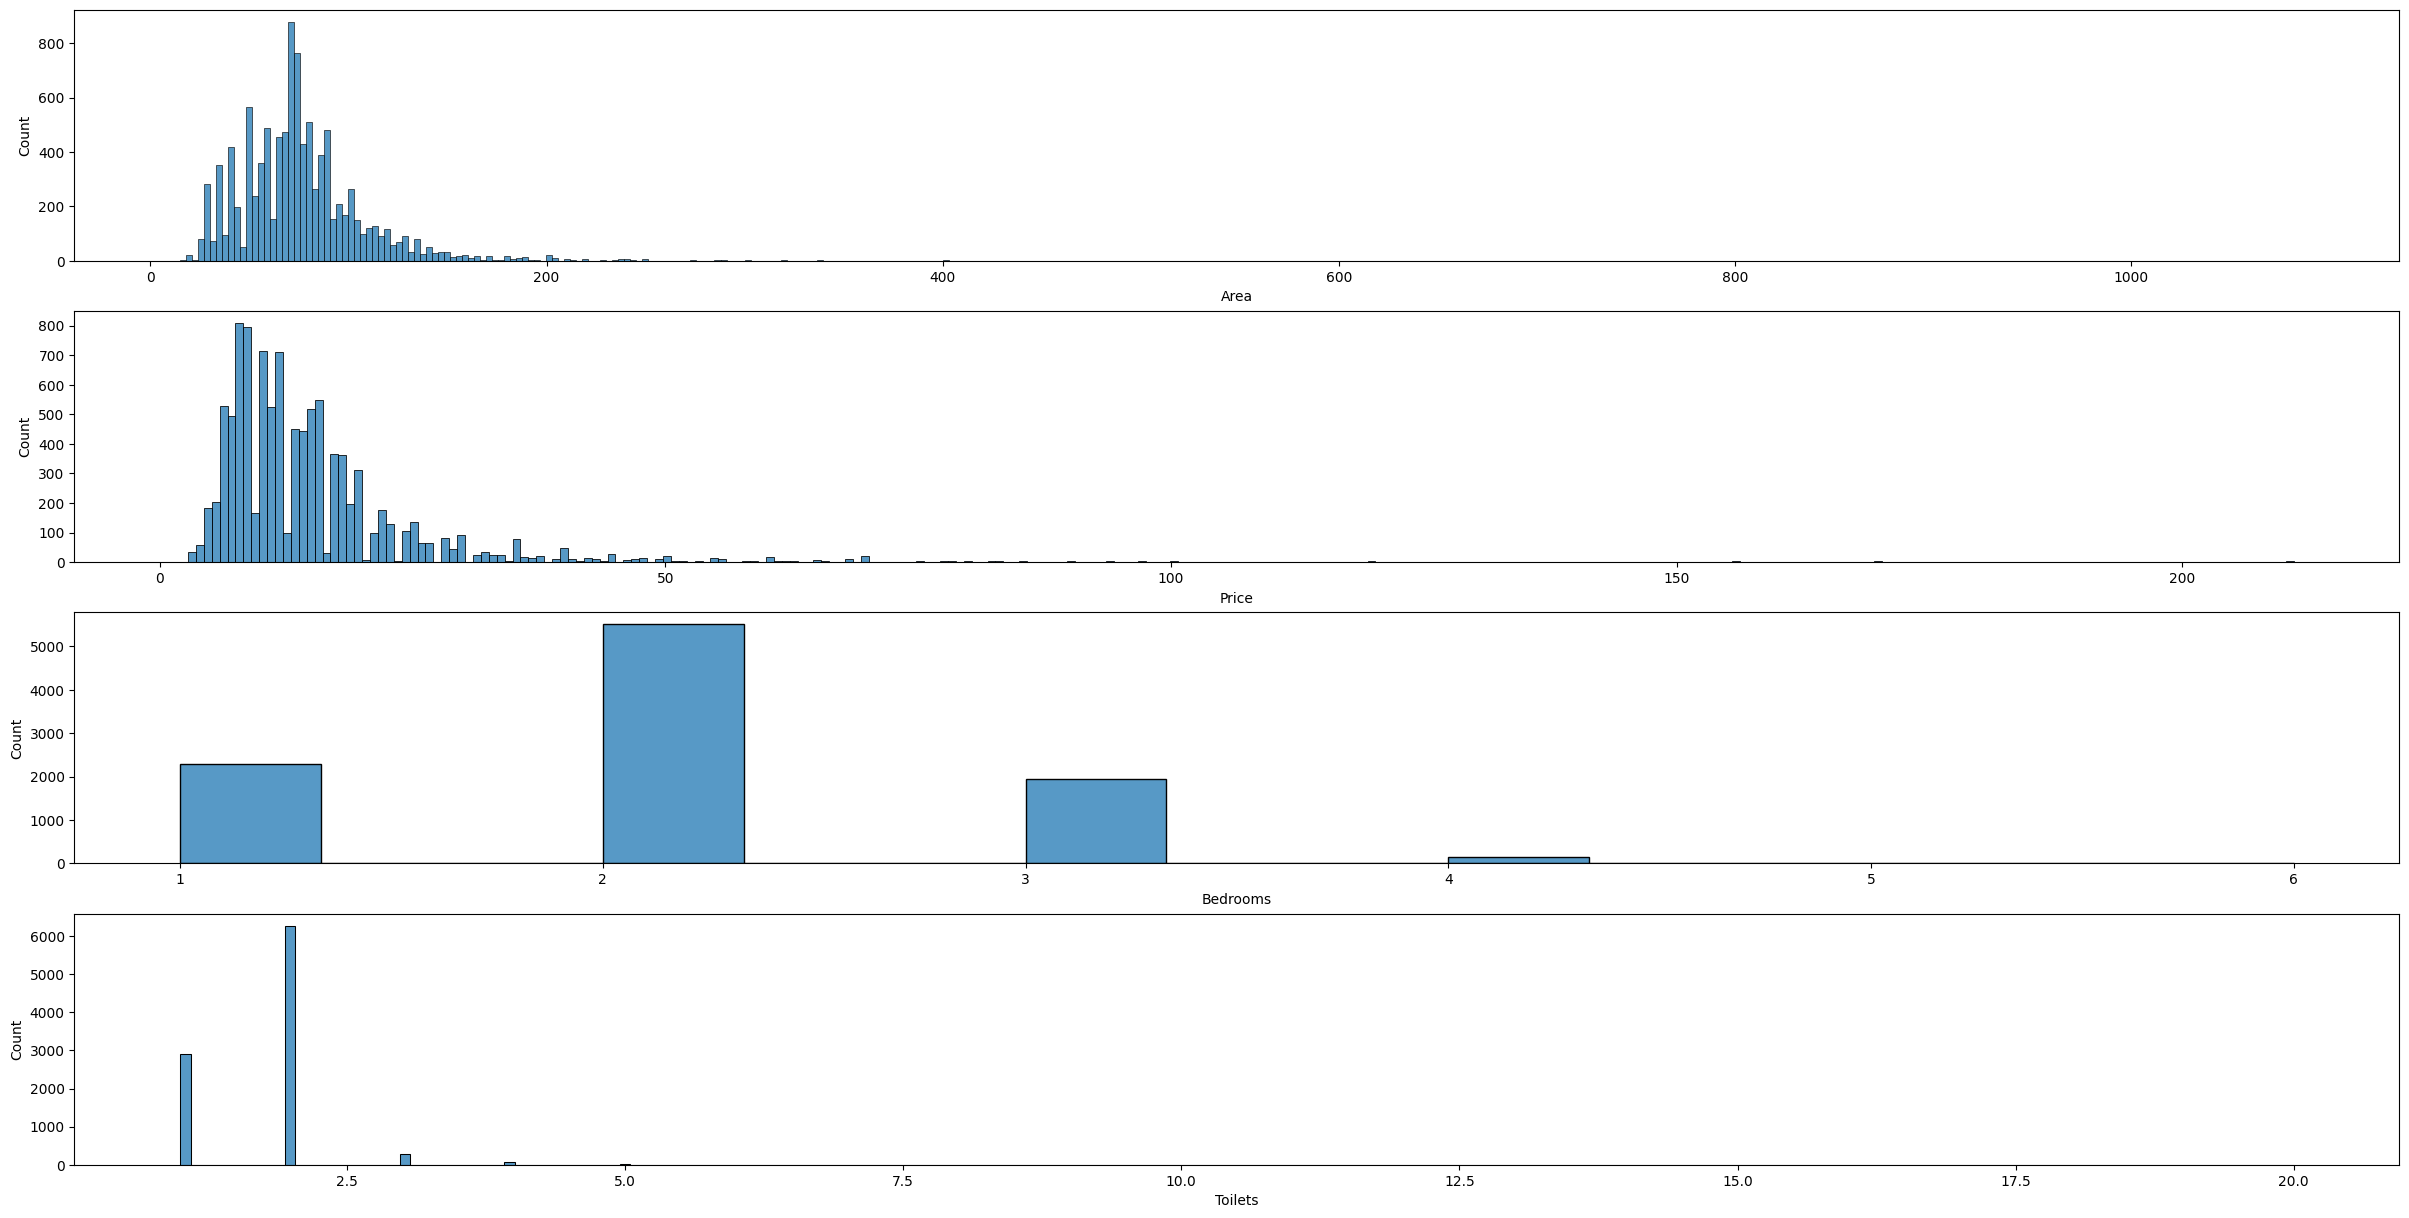

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(30, 15))

for i, column in enumerate(columns_to_plot):
    sns.histplot(x = data[column], ax=axes[i])

Now we can see the data more clearly. As we can see, the chart for `Area` and `Price` looks quite skewed, and teh chart for `Price` represent a multimodal distribution. The range of the graph is vast but the majority of data is distributed in a certain range. This suggest that we might need to remove outlines for these 2 fields.

With `Bedrooms`, we see that although the values concentrated on the the first range (very skewed), the outliner is not that far off from the mean (std is not high). There for we will keep the data as is.

With `Toilets`, most of the data is concentrated on the left from 1 - 5, but there is a very skewed outliner at 20. Similar to `Bedrooms`, because most of values are not far of from the mean, we will not perform IQR outliner removal, but we will remove the singular values of 20.

In [9]:
# Remove outliner for Toiets
data = data[data['Toilets'] != 20]

Next, let's check for missing values in the data set.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10294 entries, 0 to 38547
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rent type   10294 non-null  object 
 1   Area        10294 non-null  float64
 2   Price       10203 non-null  float64
 3   Bedrooms    9895 non-null   float64
 4   Toilets     9547 non-null   float64
 5   Furniture   10294 non-null  float64
 6   Floors      18 non-null     float64
 7   1           10294 non-null  bool   
 8   10          10294 non-null  bool   
 9   11          10294 non-null  bool   
 10  12          10294 non-null  bool   
 11  2           10294 non-null  bool   
 12  3           10294 non-null  bool   
 13  4           10294 non-null  bool   
 14  5           10294 non-null  bool   
 15  6           10294 non-null  bool   
 16  7           10294 non-null  bool   
 17  8           10294 non-null  bool   
 18  9           10294 non-null  bool   
 19  bình chánh  10294 non-null  bo

We can see that `Price`, `Bedroom`, `Toilets` and `Floors` all have missing values. 

To recap, we have to deal with the missing data for our predictive features, and the outliners in each columns.

First, let's deal with the missing data.

### 1.2 Resolve missing data

Since we are trying to build a model to predict the price of real estate rent property, we have to include `Price` data. There are 2 ways to resolve this situation:
- We filled in the missing data
- We delete the rows with missing data

With `Bedrooms` and `Toilets`, since the range of the data isn't so far off, let's fill in the missing values with mean of the values in the columns.

In [11]:
bedrooms_mean = int(data['Bedrooms'].mean())
toilet_mean = int(data['Toilets'].mean())

data['Bedrooms'].fillna(bedrooms_mean, inplace=True)
data['Toilets'].fillna(toilet_mean, inplace=True)

With `Floors`, since there are so many missing values, we are not accounting this data into our final dataset.

In [12]:
data.drop('Floors', axis=1, inplace=True)


With `Price` data, the missing data is the data that was the previously values `Thỏa thuận`. This is going to be our ultimate test dataset - the data that we want to predict the values of. Let's extract them from our dataset and remove from the test data set.

In [13]:
test_price_data = data[data['Price'].isna()]
data.dropna(subset=['Price'], inplace=True)

In [14]:
data['Bedrooms'].value_counts()

Bedrooms
2.0    5857
1.0    2269
3.0    1916
4.0     144
5.0      16
6.0       1
Name: count, dtype: int64

### 1.3 Resolve outliner

As discussed before, we will be removing the outliner for `Area` and `Price` data. We will use the IQR method for this.

In [15]:
outlined_column = ['Area', 'Price']

In [16]:
for column in outlined_column:
    column_values = data[column].to_numpy()

    q1 = np.percentile(column_values, 25)
    q3 = np.percentile(column_values, 75)
    iqr = q3 - q1

    lower_threshold = q1 - 1.5 * iqr
    upper_threshold = q3 + 1.5 * iqr

    outliers_mask = (data[column] < lower_threshold) | (data[column] > upper_threshold)

    data = data[~outliers_mask]

In [17]:
data['Bedrooms'].value_counts()

Bedrooms
2.0    5700
1.0    2254
3.0    1376
4.0       4
Name: count, dtype: int64

Let's check our data again before moving on to building our model.

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9334 entries, 0 to 38547
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rent type   9334 non-null   object 
 1   Area        9334 non-null   float64
 2   Price       9334 non-null   float64
 3   Bedrooms    9334 non-null   float64
 4   Toilets     9334 non-null   float64
 5   Furniture   9334 non-null   float64
 6   1           9334 non-null   bool   
 7   10          9334 non-null   bool   
 8   11          9334 non-null   bool   
 9   12          9334 non-null   bool   
 10  2           9334 non-null   bool   
 11  3           9334 non-null   bool   
 12  4           9334 non-null   bool   
 13  5           9334 non-null   bool   
 14  6           9334 non-null   bool   
 15  7           9334 non-null   bool   
 16  8           9334 non-null   bool   
 17  9           9334 non-null   bool   
 18  bình chánh  9334 non-null   bool   
 19  bình thạnh  9334 non-null   boo

Looks like we have gone from 10295 to 9334 values - we've remove 961 values. 

Next, let's see how the data are distributed again with our contious features.

c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

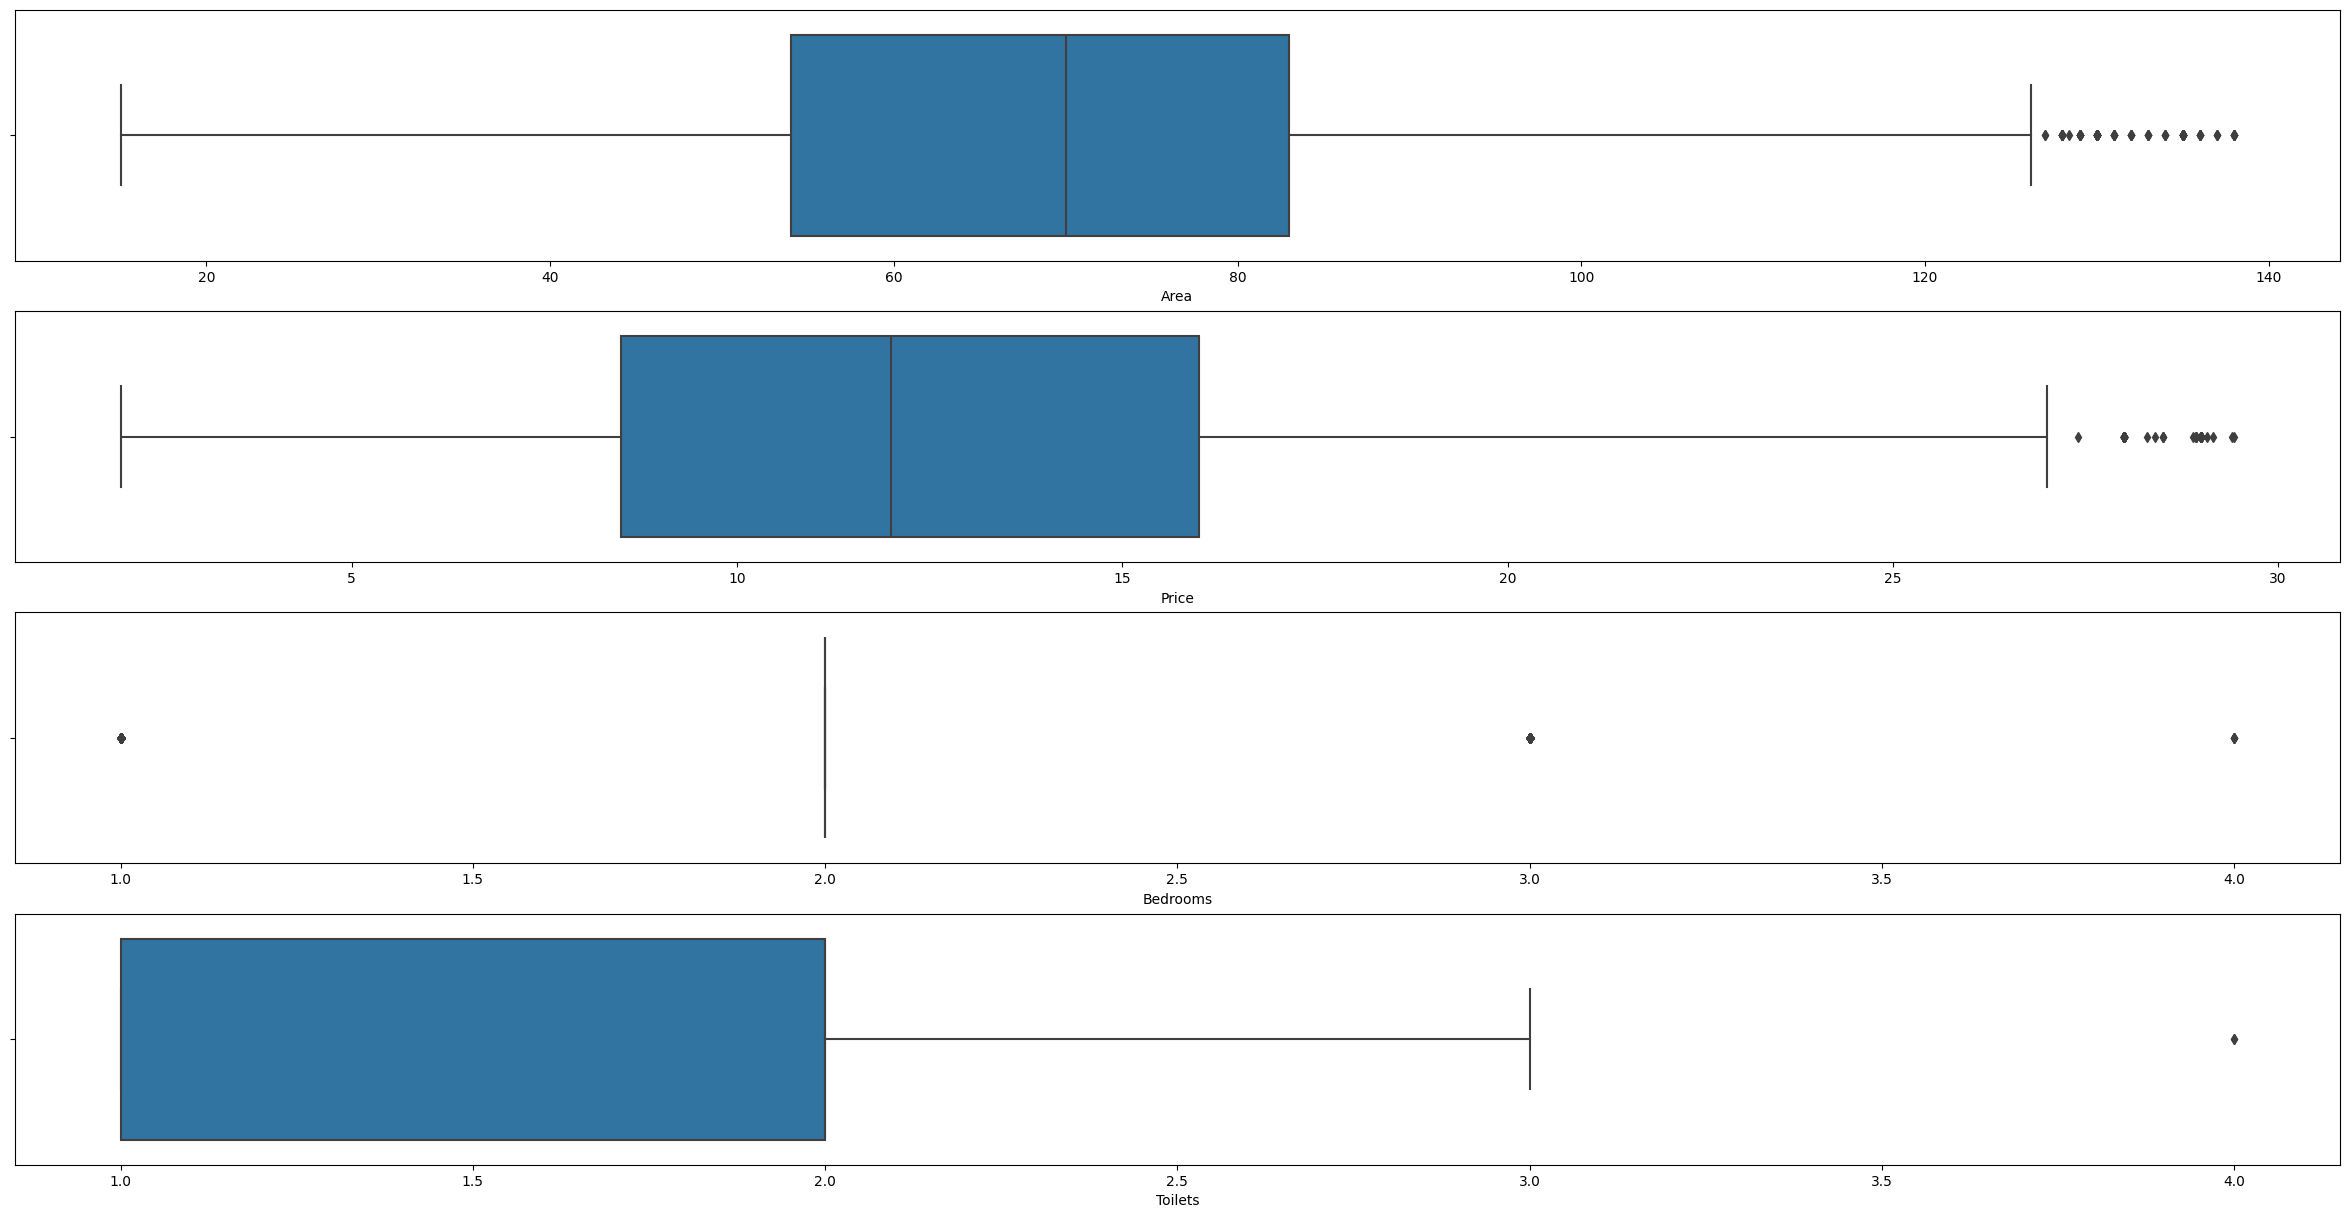

In [19]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(30, 15))

for i, column in enumerate(columns_to_plot):
    sns.boxplot(x = data[column], ax=axes[i])

There are still some outliners left, but they are fewer and less significant.

Now, let's start training our models.

## 2. Model selection

There are flavors to model selection:
1. Using `cross_val_score`: This method allows us to measure the accuracy of a models on multiple datasets to determine the best score. 
2. Using `GridSearchCV`: This method allows us to tune hyperparameters of a model while feeding k-fold datasets to determine the best hyperparameter for the model.

In practice, we can use both to do model selection. But a more realist setting, Data Scientist would most likely use `GridSearchCV` to model select and tune at the same time. We are goint with the second approach as we have already gone with the first approach in part 01.

For the data, we will using the features of `Area`, `Bedrooms`, `Toilets` and all of districts to predict price. We won't be accounting the values of `Furniture` becuase they don't have a high correlation to `Căn hộ chung cư` price in our EDA.

First, we're going to prepare our data, models and hyperparameters.

In [20]:
# Prepare predictors and response variable
# Note: we will not be using furniture data as it shows low correlation in our EDA
x = data.loc[:, ['Area', 'Bedrooms', 'Toilets', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9',
       'bình chánh', 'bình thạnh', 'bình tân', 'củ chi', 'gò vấp', 'hóc môn',
       'nhà bè', 'phú nhuận', 'thủ đức', 'tân bình', 'tân phú']]
y = data['Price']

# Prepare models params
model_params = {
    'multiple_linear_regression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False]
        }
    },
    'ridge_regression': {
        'model': Ridge(),
        'params': {'alpha': [0.1, 1, 10, 100, 0.2, 0.18, 0.19]}
    },
    'lasso_regression': {
        'model': Lasso(),
        'params': {'alpha': [0.1, 1, 10, 100, 0.2, 0.18, 0.19]}
    }, 
    'elasticnet_regression': {
        'model': ElasticNet(),
        'params': {'alpha': [0.1, 1, 10], 'l1_ratio': [0.3, 0.7, 1]}
    },
    'dtree_regression': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'random_forest':{
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],  # Number of trees in the forest
            'max_depth': [3, 5, 7, None],  # Maximum depth of the trees
            'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
            'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
        }
    }
}

Next, let's train our models and extract the results.

In [21]:
scores = []
for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=10, refit='r2', return_train_score=False)
    clf.fit(x, y)

    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'mean_score_time': np.mean(clf.cv_results_['mean_score_time']),
        'mean_fit_time': np.mean(clf.cv_results_['mean_fit_time'])
    })

Here's the result of our program.

In [22]:
pd.DataFrame(scores)

,model,best_score,best_params,mean_score_time,mean_fit_time
0,multiple_linear_regression,0.587640,{'fit_intercept': False},0.002522,0.016059
1,ridge_regression,0.587641,{'alpha': 0.1},0.001892,0.010738
2,lasso_regression,0.471158,{'alpha': 0.1},0.002611,0.018407
3,elasticnet_regression,0.481384,"{'alpha': 0.1, 'l1_ratio': 0.3}",0.002235,0.015290
4,dtree_regression,0.541051,"{'max_depth': 7, 'min_samples_leaf': 1, 'min_s...",0.002378,0.010913
5,random_forest,0.702032,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.022008,1.546768


The `Random Forest Regression` model perform the best our of our models, scoring 0.7 on `r2`, but it also takes the most time to train - require 260 times more time than `Decision Tree Regression`.

Other than that, `Multiple Linear Regression` and `Ridge Regression` perform better than the rest at about 0.58 but still a lot worst than `Random Forest Regression`. `Decision Tree Regresion` comes in third, and `Lasso Regresison` and `ElasticNet Regression` comes in last at only about 0.46 to 0.48. The bad performance might be because both algorithm can tune out certain features, which cause the models to performs well. This could means that the majority of features that is choosen in our dataset is significant.

With the result, let's choose the `Ridge Regression` to predicts our price data, since its result is second best and the time it is that fasted model to train. We will also be applying the best hyperparameter found for the model, which is `alpha` = 0.1.

## 3. Predicting values
### 3.1 Predicting `Thỏa thuận` values using `Ridge regression`

In [23]:
# Predict the price base on the given information
# Using Ridge Regression and it determined best hyperparameter
ridge_regression = Ridge(alpha=0.1)
ridge_regression.fit(x, y)
y_pred = ridge_regression.predict(test_price_data.loc[:, ['Area', 'Bedrooms', 'Toilets', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9',
       'bình chánh', 'bình thạnh', 'bình tân', 'củ chi', 'gò vấp', 'hóc môn',
       'nhà bè', 'phú nhuận', 'thủ đức', 'tân bình', 'tân phú']])

In [24]:
# Set the preditcted values to colum Price of test data
test_price_data['Price'] = y_pred
test_price_data

,Rent type,Area,Price,Bedrooms,Toilets,Furniture,1,10,11,12,...,bình thạnh,bình tân,củ chi,gò vấp,hóc môn,nhà bè,phú nhuận,thủ đức,tân bình,tân phú
7,Căn hộ chung cư,99.0,17.115041,2.0,3.0,3.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13,Căn hộ chung cư,73.0,16.157380,2.0,1.0,0.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
39,Căn hộ chung cư,72.0,16.215800,2.0,2.0,0.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
105,Căn hộ chung cư,54.0,11.408726,1.0,1.0,3.0,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
215,Căn hộ chung cư,84.0,18.944233,2.0,2.0,3.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32634,Căn hộ chung cư,120.0,22.772602,3.0,1.0,0.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
32672,Căn hộ chung cư,75.0,15.642074,2.0,2.0,3.0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
33250,Căn hộ chung cư,70.0,10.843094,2.0,1.0,3.0,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
33856,Căn hộ chung cư,118.0,19.431040,3.0,2.0,3.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### 3.2 Validate predicted values

Let's take a peek at our data to see if the result is reasonable. We will check the basic descriptive parameters of the price to see if it is reasonable (if it's within reasonable price, not negitive number, not too big...)

In [25]:
print("Maximum predicted price", test_price_data['Price'].max())
print("Minimum predicted price", test_price_data['Price'].min())
print("Mean of predicted price", test_price_data['Price'].mean())
print("Median of predicted price", test_price_data['Price'].median())

Maximum predicted price 42.949363360088405
Minimum predicted price 6.150142698270754
Mean of predicted price 16.139149318191272
Median of predicted price 15.229948966609074


We see that the price falls in a reasonable range. This is good, since that mean our models - although not *perfect*, is able to predict price range modestly and resonably.


### 4. Deploy the model

Similar to Part 01, we will be deploying our model using Streamlit.

In [26]:
joblib.dump(ridge_regression, "../Deploy/decision_tree_model_for_rent.sav")

['../Deploy/decision_tree_model_for_rent.sav']


---

That's conclude our model building process. Last but not least, we're be conluding by looking back at our project, what we have done right and what we could do better. 